In [174]:
import json
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

In [189]:
dataset = '../recomb_ssc.hg38'

In [190]:
ssc_old_id_to_new_id = dict()
with open('../data/ssc.id_map.from.repository', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        ssc_old_id_to_new_id[pieces[1]] = pieces[0]
        ssc_old_id_to_new_id[pieces[1].replace('.', '_')] = pieces[0]

In [191]:
with open('%s/deletions.json' % dataset, 'r') as f:
    deletions = json.load(f)
    
with open('%s/crossovers.json' % dataset, 'r') as f:
    crossovers = json.load(f)
    
print('deletions', len(deletions))
print('crossovers', len(crossovers))

deletions 440707
crossovers 270750


In [192]:
print(len([x for x in crossovers if x['deletions']]), 
      len([x for x in crossovers if x['deletions']])/len(crossovers))

9 3.3240997229916896e-05


In [193]:
for x in crossovers:
    if x['deletions']:
        print(x)

{'family': '11520', 'chrom': '19', 'start_pos': 35363380, 'end_pos': 35520093, 'child': ['SSC02099', 'SSC02117'], 'is_mat': True, 'is_pat': False, 'is_complex': True, 'recombinations': [['11520', '19', 35363380, 35365370, ['SSC02099', 'SSC02117'], True, False, 4, 'SSC02106', 'SSC02114', True], ['11520', '19', 35373433, 35373789, ['SSC02099', 'SSC02117'], True, False, 4, 'SSC02106', 'SSC02114', False], ['11520', '19', 35519784, 35520093, ['SSC02099', 'SSC02117'], True, False, 4, 'SSC02106', 'SSC02114', False]], 'family_size': 4, 'mom': 'SSC02106', 'dad': 'SSC02114', 'deletions': True}
{'family': '11644', 'chrom': '13', 'start_pos': 97875612, 'end_pos': 97882510, 'child': ['SSC03004', 'SSC03127'], 'is_mat': True, 'is_pat': False, 'is_complex': False, 'recombinations': [['11644', '13', 97875612, 97882510, ['SSC03004', 'SSC03127'], True, False, 4, 'SSC03006', 'SSC03126', True]], 'family_size': 4, 'mom': 'SSC03006', 'dad': 'SSC03126', 'deletions': True}
{'family': '12252', 'chrom': '4', 'st

In [180]:
# transfer acgh info

def key_to_del(d):
    return (d['family'], d['is_mat'], d['chrom'], d['start_pos'], d['end_pos'], tuple(sorted(d['trans'])))
def key_to_cross(d):
    return (d['family'], d['is_mat'], d['chrom'], d['start_pos'], d['end_pos'], tuple(sorted(d['child'])))
def pull_acgh(d):
    acgh = []
    for key, value in d.items():
        if key=='num_markers':
            acgh.append((key, value))
        elif 'aCGH' in key:
            acgh.append((key, value))
    return acgh

with open('../phased_ssc_del_qs/deletions.json', 'r') as f:
    key_to_acgh = dict([(key_to_del(d), pull_acgh(d)) for d in json.load(f)])
    

for d in deletions:
    key = key_to_del(d)
    if key in key_to_acgh:
        d.update(key_to_acgh[key])
    

In [181]:
families = sorted(set([x['family'] for x in deletions]) | set([x['family'] for x in crossovers]))
print('families', len(families))


families 483


In [182]:
del_crossover_pairs = []

for chrom in [str(x) for x in range(1, 23)]:
    chrom_dels = [x for x in deletions if x['chrom']==chrom]
    chrom_cross = [x for x in crossovers if x['chrom']==chrom]
    for family in families:
        fam_mat_dels = [x for x in chrom_dels if x['family']==family and x['is_mat']]
        fam_mat_cross = [x for x in chrom_cross if x['family']==family and x['is_mat']]

        mat_del_starts = np.array([x['start_pos'] for x in fam_mat_dels])
        mat_del_ends = np.array([x['end_pos'] for x in fam_mat_dels])

        for c in fam_mat_cross:
            overlap = np.minimum(mat_del_ends, c['end_pos'])-np.maximum(mat_del_starts, c['start_pos'])
            for i in np.where(overlap>0)[0]:
                del_crossover_pairs.append((fam_mat_dels[i], c))

        fam_pat_dels = [x for x in chrom_dels if x['family']==family and x['is_pat']]
        fam_pat_cross = [x for x in chrom_cross if x['family']==family and x['is_pat']]

        pat_del_starts = np.array([x['start_pos'] for x in fam_pat_dels])
        pat_del_ends = np.array([x['end_pos'] for x in fam_pat_dels])

        for c in fam_pat_cross:
            overlap = np.minimum(pat_del_ends, c['end_pos'])-np.maximum(pat_del_starts, c['start_pos'])
            for i in np.where(overlap>0)[0]:
                del_crossover_pairs.append((fam_pat_dels[i], c))

In [183]:
print(len(del_crossover_pairs))
print('frac deletions', len(del_crossover_pairs)/len(deletions))
print('frac crossovers', len(del_crossover_pairs)/len(crossovers))

812
frac deletions 0.007855049190794501
frac crossovers 0.01154934786009928


In [173]:
key_to_deletion = dict([(key_to_del(d), d) for d in deletions])

delkeys_in_cross = set([key_to_del(d) for d, c in del_crossover_pairs])
crosskeys_in_del = set([key_to_cross(c) for d, c in del_crossover_pairs])

print(len(delkeys_in_cross), len(del_crossover_pairs))
print(len(crosskeys_in_del), len(del_crossover_pairs))
print(len(delkeys_notin_cross))

812 812
476 812
96168


In [ ]:
print(Counter([len(key_to_deletion[d]['trans']) for d in delkeys_in_cross]))

delkeys_in_cross_single_trans = [d for d in delkeys_in_cross if len(key_to_deletion[d]['trans'])==1]
delkeys_in_cross_double_trans = [d for d in delkeys_in_cross if len(key_to_deletion[d]['trans'])==2]
print(len(delkeys_in_cross_single_trans))

In [133]:
def is_validated(d, index=0):
    child = d['trans'][index]
    child_acgh = d.get('%s_med_aCGH' % child, None)
    nodel_parent = d['mother'] if d['is_pat'] else d['father']
    nodel_parent_acgh = d.get('%s_med_aCGH' % nodel_parent, None)
    
    if child_acgh is not None and nodel_parent_acgh is not None and not d['is_hts'] and d['length']>1000:
        return (np.log2(child_acgh)<-0.25) or (np.log2(child_acgh)-np.log2(nodel_parent_acgh)<-0.25)
    else:
        return None

In [134]:
no_cross_single_trans_val, no_cross_single_trans_noval = 0, 0
for d in set([key_to_del(d) for d in deletions]) - delkeys_in_cross:
    is_val = is_validated(key_to_deletion[d])
    if is_val is not None:
        if is_val:
            no_cross_single_trans_val += 1
        else:
            no_cross_single_trans_noval += 1
            
print(no_cross_single_trans_val, no_cross_single_trans_noval, no_cross_single_trans_val/(no_cross_single_trans_val+no_cross_single_trans_noval))



8268 3452 0.7054607508532423


In [135]:
in_cross_single_trans_val, in_cross_single_trans_noval = 0, 0
for d in delkeys_in_cross_single_trans:
    is_val = is_validated(key_to_deletion[d])
    if is_val is not None:
        if is_val:
            in_cross_single_trans_val += 1
        else:
            in_cross_single_trans_noval += 1
            
print(in_cross_single_trans_val, in_cross_single_trans_noval, in_cross_single_trans_val/(in_cross_single_trans_val+in_cross_single_trans_noval))
    
    

269 125 0.682741116751269


In [136]:
in_cross_double_trans_bothval, in_cross_double_trans_oneval, in_cross_double_trans_noval = 0, 0, 0
for d in delkeys_in_cross_double_trans:
    is_val1 = is_validated(key_to_deletion[d])
    is_val2 = is_validated(key_to_deletion[d], index=1)
    if is_val1 is not None and is_val2 is not None:
        if is_val1 and is_val2:
            in_cross_double_trans_bothval += 1
        elif is_val1 or is_val2:
            in_cross_double_trans_oneval += 1
        else:
            in_cross_double_trans_noval += 1
            
print(in_cross_double_trans_bothval, in_cross_double_trans_oneval, in_cross_double_trans_noval,
      (2*in_cross_double_trans_bothval + in_cross_double_trans_oneval)/(2*in_cross_double_trans_bothval + 2*in_cross_double_trans_oneval + 2*in_cross_double_trans_noval))
    
    

210 45 64 0.7288401253918495


In [137]:
print(np.sum([key_to_deletion[d]['is_hts'] for d in delkeys_in_cross_single_trans])/len(delkeys_in_cross_single_trans))



0.49845440494590415


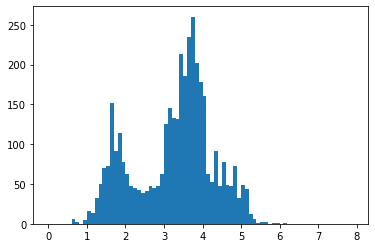

In [130]:
plt.hist(np.log10([key_to_deletion[d]['length'] for d in delkeys_in_cross if not key_to_deletion[d]['is_hts'] ]), bins=np.arange(0, 8, 0.1))
plt.show()